# Волкова Татьяна, ПИ19-4, подгруппа 3

База данных содержит информацию о клиентах банка, их счетах, которые могут быть нескольких типов, а также информацию об фин. операциях (переводы между счетами). Есть также таблица об городах в которых могут жить клиенты или находиться банк.
clients - Таблица клиентов содержит: фамилию, имя, серию и номер паспорта, адрес и номер телефона (уникален), все поля обязательны для заполнения, а также id, который является первичным ключм.
towns - Таблица городов содержит: название города и соответствующий id, который является первичным ключм. Все поля обязательны для заполнения.
types - Таблица типов счетов содержит: id, который является первичным ключм, и соответствующую расшифровку типа (типы уникальны). Все поля обязательны для заполнения.
bills - Таблица счетов содержит: номер счета (является первичным ключом), дату открытия и закрытия счета (дата открытия по умолчанию -  текущая дата). Данная таблица связана с таблицой типов счетов и таблицей клиентов  соответсвенно через id типа и id клиента.  Все поля обязательны для заполнения.
operations - Таблица операций содержит: id операции (являетсе первичным ключом), тип операции, сумму перевода, дату операции (по умолчанию - текущая). Данная таблица связана с таблицой счетов и таблицей клиентов  соответсвенно через id счета и id клиента.  Все поля обязательны для заполнения.
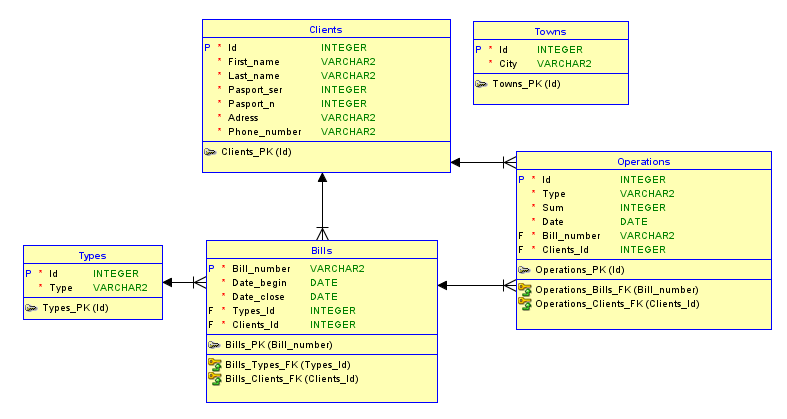

## Создание таблиц

In [1]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///bank.db')

from sqlalchemy import MetaData
metadata = MetaData()

from datetime import datetime
from sqlalchemy import (Table, Column, Integer, String, DateTime, ForeignKey)
from sqlalchemy import PrimaryKeyConstraint, UniqueConstraint, CheckConstraint

clients=Table('clients',metadata,
               Column('id',Integer(),primary_key=True),
               Column('first_name',String(50),nullable=False),
               Column('last_name',String(50),nullable=False),
               Column('pasport_ser',Integer(),nullable=False),
               Column('pasport_n',Integer(),nullable=False),
               Column('adress',String(255),nullable=False),
               Column('phone_number',Integer(),nullable=False,unique=True),
               extend_existing=True
             )

towns=Table('towns',metadata,
               Column('id',Integer(),primary_key=True),
               Column('town',String(50),nullable=False),
               extend_existing=True
             )

types=Table('types',metadata,
               Column('id',Integer(),primary_key=True),
               Column('type',String(50),nullable=False,unique=True),
               extend_existing=True
             )

bills=Table('bills',metadata,
               Column('bill_number',Integer(),primary_key=True),
               #Column('date_begin',DateTime(),default=datetime.now,nullable=False),
               Column('date_begin',String(50), nullable=False),
               Column('date_close',String(50)),
               Column('types_id',ForeignKey('types.id')),
               Column('clients_id',ForeignKey('clients.id')),
               extend_existing=True
             )

operations=Table('operations',metadata,
               Column('id',Integer(),primary_key=True),
               Column('type',String(50),nullable=False),
               Column('sum',Integer(),nullable=False),                 
               #Column('date',DateTime(),default=datetime.now,nullable=False),
               Column('date',String(50),nullable=False),
               Column('bill_number',ForeignKey('bills.bill_number')),
               Column('clients_id',ForeignKey('clients.id')),
               extend_existing=True
             )

metadata.create_all(engine)

## Вставка данных

In [2]:
connection=engine.connect()

ins=clients.insert().values(
    id = 1,
    first_name = 'Tatiana',
    last_name = 'Volkova',
    pasport_ser = 1747,
    pasport_n = 132675,
    adress = 'Zhucovsky, Osipenko',
    phone_number = 89055039142
)
result=connection.execute(ins)

ins=clients.insert().values(
    id = 2,
    first_name = 'Bair',
    last_name = 'Badmaev',
    pasport_ser = 1747,
    pasport_n = 154325,
    adress = 'Moskow, Sherbakovka',
    phone_number = 88005553535
)
result=connection.execute(ins)

ins=clients.insert().values(
    id = 3,
    first_name = 'Ivan',
    last_name = 'Bedak',
    pasport_ser = 1747,
    pasport_n = 132543,
    adress = 'Moskow, Somwhere',
    phone_number = 89003245423
)

result=connection.execute(ins)

def insert_values(table, values_list):
    for value in values_list:
        ins = table.insert().values(value)
        connection.execute(ins)
        
towns_list = [
    (11, 'Moskow'),
    (12, 'Zhukovsky'),
    (13, 'Anapa')
]

insert_values(towns, towns_list)

types_list = [
    (21, 'Credit'),
    (22, 'Social'),
    (23, 'TinkoffBlack')
]

insert_values(types, types_list)

bills_list = [
    (1232312321, "2021.4.2", "2025.4.2", 22, 1),
    (1232354376, "2021.4.2", "2025.4.2", 22, 2),
    (1232354763, "2021.4.2", "2025.4.2", 22, 3)
]

insert_values(bills, bills_list)

operations_list = [
    (123, 'stipend', 1950, "2021.4.2", 1232312321, 1),
    (125, 'stipend', 2500, "2021.4.2", 1232354376, 2),
    (126, 'stipend', 1950, "2021.4.2", 1232354763, 3)
]
insert_values(operations, operations_list)

## Обработка ошибок и трансакции

In [4]:
from sqlalchemy.exc import IntegrityError
from sqlalchemy.sql import func
from sqlalchemy import select

#пытаемся провести операцию, но операция с таким номером ужесуществует

s=select([func.max(operations.c.id)])
rp=connection.execute(s).scalar()
max_operation_id = rp
print(f'Макс. значение номера операции: {max_operation_id}')

ins=operations.insert().values(
    id = 126,
    type = 'stipend',
    sum = 2500,
    date = "2021.4.2",
    bill_number = 1232354763,
    clients_id = 3
)

transaction = connection.begin()

try:
    result=connection.execute(ins)
except IntegrityError as error:
    transaction.rollback()
    print(error)
    
s=select([func.max(operations.c.id)])
rp=connection.execute(s).scalar()
max_operation_id = rp
print(f'Макс. значение номера операции: {max_operation_id}')

Макс. значение номера операции: 126
(sqlite3.IntegrityError) UNIQUE constraint failed: operations.id
[SQL: INSERT INTO operations (id, type, sum, date, bill_number, clients_id) VALUES (?, ?, ?, ?, ?, ?)]
[parameters: (126, 'stipend', 2500, '2021.4.2', 1232354763, 3)]
(Background on this error at: http://sqlalche.me/e/gkpj)
Макс. значение номера операции: 126


In [5]:
#если не существует все хорошо работает

s=select([func.max(operations.c.id)])
rp=connection.execute(s).scalar()
max_operation_id = rp
print(f'Макс. значение номера операции: {max_operation_id}')

ins=operations.insert().values(
    id = 127,
    type = 'stipend',
    sum = 2500,
    date = "2021.4.2",
    bill_number = 1232354763,
    clients_id = 3
)

try:
    result=connection.execute(ins)
except IntegrityError as error:
    transaction.rollback()
    print(error)
    
s=select([func.max(operations.c.id)])
rp=connection.execute(s).scalar()
max_operation_id = rp
print(f'Макс. значение номера операции: {max_operation_id}')

Макс. значение номера операции: 126
Макс. значение номера операции: 127


In [ ]:
#towns_list = [
#    (13, 'Anapa'),
#    (14, 'Smt')
#]

#for town in towns_list:
#    transaction = connection.begin()
#    ins=operations.insert().values(town)
#    transaction = connection.begin()   
#    try:
#        result=connection.execute(ins)
#    except IntegrityError as error:
#        transaction.rollback()
#        print(error)


## Отображение

In [6]:
connection=engine.connect()

operations = Table('operations', metadata, autoload=True, autoload_with=engine)
print(operations.columns.keys())
s = select([operations])
print(engine.execute(s).fetchall())

['id', 'type', 'sum', 'date', 'bill_number', 'clients_id']
[(123, 'stipend', 1950, '2021.4.2', 1232312321, 1), (125, 'stipend', 2500, '2021.4.2', 1232354376, 2), (126, 'stipend', 1950, '2021.4.2', 1232354763, 3), (127, 'stipend', 2500, '2021.4.2', 1232354763, 3)]


In [8]:
#foreign key есть и восстанавливать отношение не надо
metadata.tables['bills']

Table('bills', MetaData(bind=None), Column('bill_number', Integer(), table=<bills>, primary_key=True, nullable=False), Column('date_begin', String(length=50), table=<bills>, nullable=False), Column('date_close', String(length=50), table=<bills>), Column('types_id', Integer(), ForeignKey('types.id'), table=<bills>), Column('clients_id', Integer(), ForeignKey('clients.id'), table=<bills>), schema=None)

In [9]:
res = select([operations.columns.id])
res = res.select_from(operations.join(bills))
res = res.where(bills.columns.clients_id == 3)

connection.execute(res).fetchall()

[(126,), (127,)]

In [10]:
 metadata.tables.keys()

dict_keys(['clients', 'towns', 'types', 'bills', 'operations'])